<a id='1.1'></a>
## Install all the packages through FinRL library


In [1]:
## install finrl library
# !pip install git+https://github.com/amritgos/FinRL.git

In [2]:
# !git clone -q https://github.com/amritgos/FinRL.git

In [3]:
# cd FinRL


<a id='1.2'></a>
## Packages Required 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv

from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

import sys
sys.path.append("../FinRL")

/home/amritgos/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Downloading Data


In [3]:
print(config.SENSEX_30_TICKER)

['ASIANPAINT.BO' 'AXISBANK.BO' 'BAJAJ-AUTO.BO' 'BAJFINANCE.BO'
 'BAJAJFINSV.BO' 'BHARTIARTL.BO' 'DRREDDY.BO' 'HCLTECH.BO' 'HDFC.BO'
 'HDFCBANK.BO' 'HINDUNILVR.BO' 'ICICIBANK.BO' 'INDUSINDBK.BO' 'INFY.BO'
 'ITC.BO' 'KOTAKBANK.BO' 'LT.BO' 'M&M.BO' 'MARUTI.BO' 'NESTLEIND.BO'
 'NTPC.BO' 'ONGC.BO' 'POWERGRID.BO' 'RELIANCE.BO' 'SBIN.BO' 'SUNPHARMA.BO'
 'TCS.BO' 'TECHM.BO' 'TITAN.BO' 'ULTRACEMCO.BO']


In [4]:
try:
    df = pd.read_csv('datasets/Price_data.csv')
except:
    df = YahooDownloader(start_date = '2016-01-01',
                        end_date = '2021-01-01',
                        ticker_list = config.SENSEX_30_TICKER).fetch_data()
    df.to_csv('datasets/Price_data.csv', index=False)

In [5]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2016-01-01,882.950012,885.500000,878.500000,847.758850,17377.0,ASIANPAINT.BO,4
1,2016-01-01,450.000000,452.700012,445.799988,440.748108,433052.0,AXISBANK.BO,4
2,2016-01-01,2530.000000,2530.000000,2512.149902,2137.924316,9055.0,BAJAJ-AUTO.BO,4
3,2016-01-01,1990.000000,2010.000000,1960.500000,1980.499756,6305.0,BAJAJFINSV.BO,4
4,2016-01-01,602.255005,609.994995,600.590027,600.510315,10350.0,BAJFINANCE.BO,4


In [6]:
df.shape

(36960, 8)

# Preprocessing Data


In [9]:
# vix_df = pd.read_csv('datasets/IndiaVIX_data.csv')
sentiment_df = pd.read_csv('datasets/Sentiment_Compiled.csv')

In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=False,
                    use_turbulence=False,
                    use_vix=False,
                    vix_df=None,
                    use_sentiment=True,
                    sentiment_df=sentiment_df,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added Sentiment Features


In [13]:
df.shape

(36960, 10)

In [14]:
df.head()

,date,open,high,low,close,volume,tic,day,tweets,news
0,2016-01-01,882.950012,885.500000,878.500000,847.758850,17377.0,ASIANPAINT.BO,4,0.000000,0.350317
1,2016-01-01,450.000000,452.700012,445.799988,440.748108,433052.0,AXISBANK.BO,4,-0.256360,0.148355
2,2016-01-01,2530.000000,2530.000000,2512.149902,2137.924316,9055.0,BAJAJ-AUTO.BO,4,0.191883,0.182735
3,2016-01-01,1990.000000,2010.000000,1960.500000,1980.499756,6305.0,BAJAJFINSV.BO,4,0.000000,0.235760
4,2016-01-01,602.255005,609.994995,600.590027,600.510315,10350.0,BAJFINANCE.BO,4,0.243754,0.184951


<a id='4'></a>
# Setting up Environment


## Training data split: 2009-01-01 to 2018-12-31

In [15]:
train = data_split(df, '2016-01-01','2019-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [16]:
train.head()

,date,open,high,low,close,volume,tic,day,tweets,news
0,2016-01-01,882.950012,885.500000,878.500000,847.758850,17377.0,ASIANPAINT.BO,4,0.000000,0.350317
0,2016-01-01,450.000000,452.700012,445.799988,440.748108,433052.0,AXISBANK.BO,4,-0.256360,0.148355
0,2016-01-01,2530.000000,2530.000000,2512.149902,2137.924316,9055.0,BAJAJ-AUTO.BO,4,0.191883,0.182735
0,2016-01-01,1990.000000,2010.000000,1960.500000,1980.499756,6305.0,BAJAJFINSV.BO,4,0.000000,0.235760
0,2016-01-01,602.255005,609.994995,600.590027,600.510315,10350.0,BAJFINANCE.BO,4,0.243754,0.184951


## Environment for Portfolio Optimization


In [17]:
sent = 1
tech = 0
user = 0
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + (tech*len(config.TECHNICAL_INDICATORS_LIST)+sent*len(config.SENTIMENT_INDICATORS_LIST)+user*len(config.USER_INDICATORS_LIST))*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 121


In [18]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    # "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "tech_indicator_list": [],
    "sentiment_indicator_list": config.SENTIMENT_INDICATORS_LIST, 
    "user_indicator_list": [],
    # "user_indicator_list": config.USER_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "turbulence_threshold": None,
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# A2C Algorithm

In [20]:
# initialize
agent = DRLAgent(env = env_train)

In [21]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.005}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.005}
Using cpu device


In [22]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=100000)

Logging to tensorboard_log/a2c/a2c_4
------------------------------------
| time/                 |          |
|    fps                | 61       |
|    iterations         | 100      |
|    time_elapsed       | 8        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.005    |
|    n_updates          | 99       |
|    policy_loss        | -27      |
|    std                | 0.997    |
|    value_loss         | 0.781    |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.26e+06 |
|    total_cost         | 2.27e+04 |
|    total_reward       | 1.26e+06 |
|    total_reward_pct   | 126      |
|    total_trades       | 13691    |
| time/                 |          |
|    fps                | 70       |
|    iterations         | 200      |
|    time_elapsed       | 14       |
|

## Trading
Assume that we have Rs10,00,000 initial capital at 2019-01-01. We use the A2C model to trade SENSEX stocks.

In [24]:
data_turbulence = train[(df.date<'2019-07-01') & (df.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

/home/amritgos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [25]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,0.95)

AttributeError: 'DataFrame' object has no attribute 'turbulence'

In [ ]:
data_vix = processed[(df.date<'2019-01-01') & (df.date>='2009-01-01')]
insample_vix = data_turbulence.drop_duplicates(subset=['date'])

In [ ]:
vix_threshold = np.quantile(insample_vix.VIX.values,0.95)

In [41]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    # "turbulence_threshold": turbulence_threshold,
    # "vix_threshold": vix_threshold,
    "reward_scaling": 1e-4
    
}

In [42]:
trade = data_split(df,'2019-07-01', '2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [43]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

hit end!


In [44]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Backtesting methodology

<a id='6.1'></a>
## BackTestStats


In [45]:
from pyfolio import timeseries
s1 = get_daily_return(df_daily_return, value_col_name="account_value")
df_daily_return['daily_return'] = s1.values
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [46]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.126612
Cumulative returns     0.192419
Annual volatility      0.292144
Sharpe ratio           0.556959
Calmar ratio           0.344053
Stability              0.030419
Max drawdown          -0.368003
Omega ratio            1.117384
Sortino ratio          0.765726
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959231
Daily value at risk   -0.036161
Alpha                  0.000000
Beta                   1.000000
dtype: float64

<a id='6.2'></a>
## BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (371, 8)


Start date,2019-07-01
End date,2020-12-31
Total months,17
,Backtest
Annual return,12.661%
Cumulative returns,19.242%
Annual volatility,29.214%
Sharpe ratio,0.56
Calmar ratio,0.34
Stability,0.03
Max drawdown,-36.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.80,2020-01-27,2020-03-24,2020-10-21,193
1,12.00,2019-07-04,2019-08-22,2020-01-24,147
2,3.11,2020-12-18,2020-12-21,2020-12-28,7
3,3.02,2020-10-21,2020-11-02,2020-11-09,14
4,2.34,2020-12-08,2020-12-10,2020-12-18,9


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2020-01-01 00:00:00+00:00'], dtype='datetime64[ns, UTC]', name='date', freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

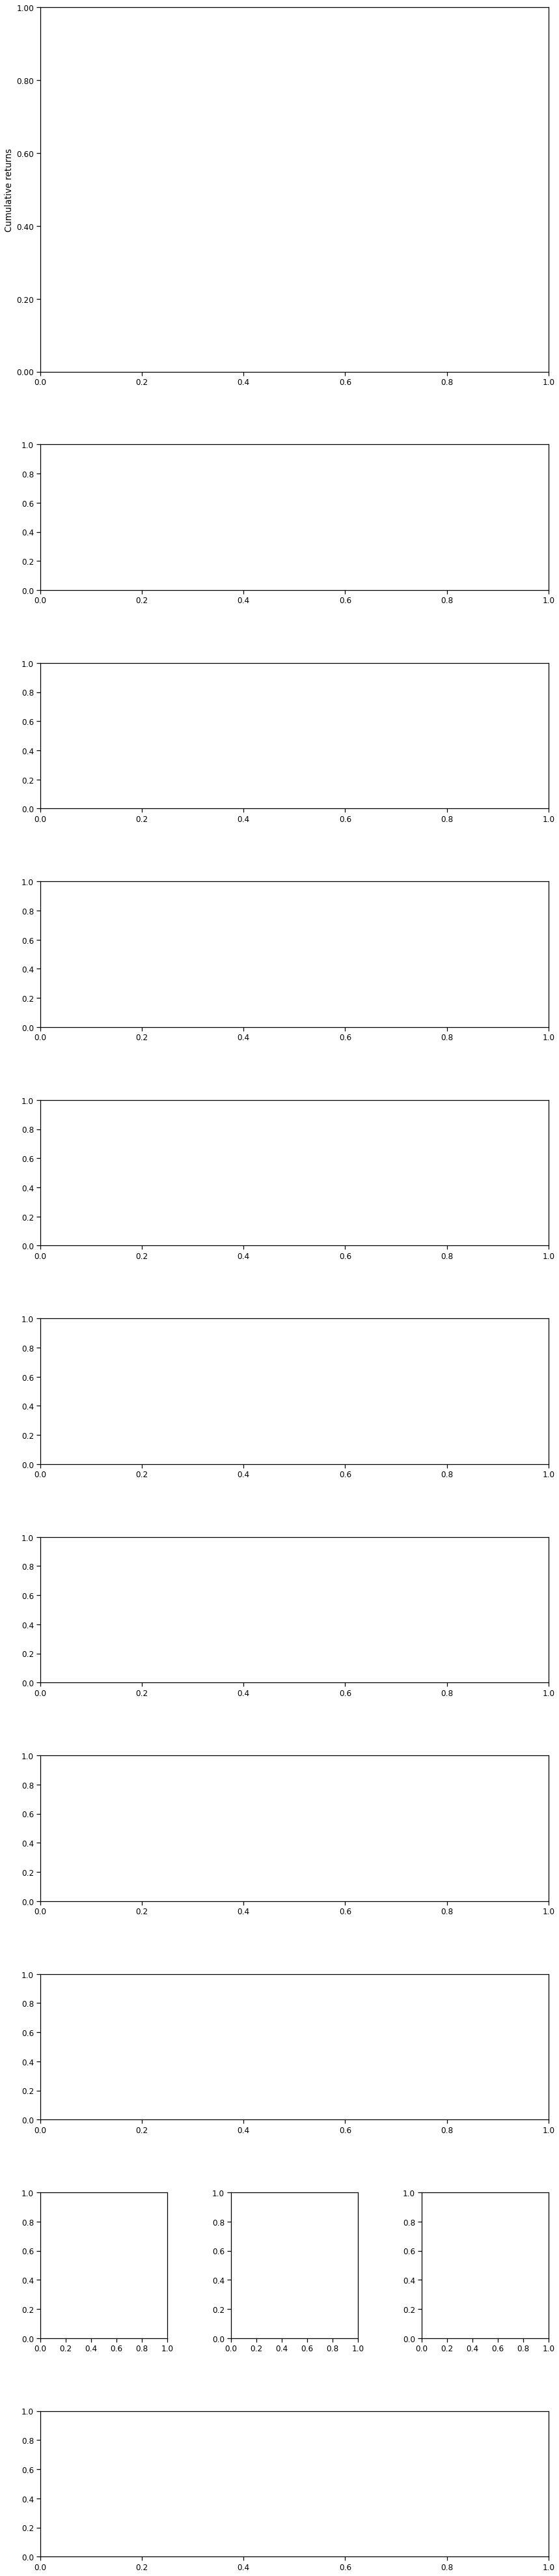

In [47]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^BSESN', start='2019-07-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)